<a href="https://colab.research.google.com/github/matherialist/Stepik-ML-contest/blob/master/Stepik_ML_Contest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
sns.set(rc={'figure.figsize': (10, 5)})

In [4]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [5]:
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [6]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [0]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date

In [8]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


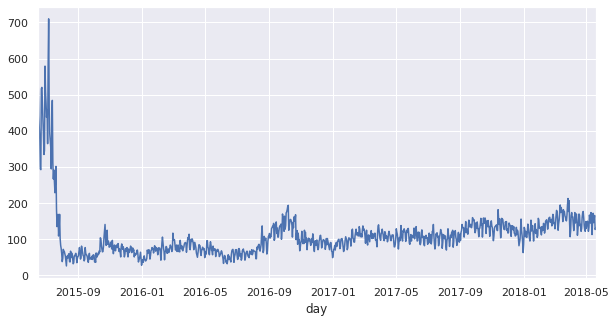

In [9]:
events_data.groupby('day').user_id.nunique().plot()

In [0]:
users_events_data = events_data.pivot_table(index='user_id', columns='action', values='step_id',
                        aggfunc='count', fill_value=0).reset_index()

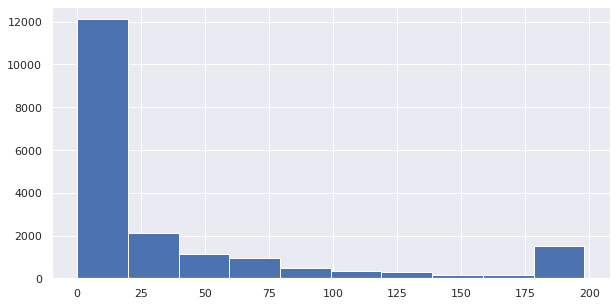

In [11]:
users_events_data.discovered.hist()

In [12]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [0]:
users_scores = submissions_data.pivot_table(index='user_id', columns='submission_status', 
                                            values='step_id', aggfunc='count', fill_value=0).reset_index()

In [0]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
                        .groupby('user_id')['timestamp'].apply(list).apply(np.diff).values

In [0]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24 * 60 * 60)

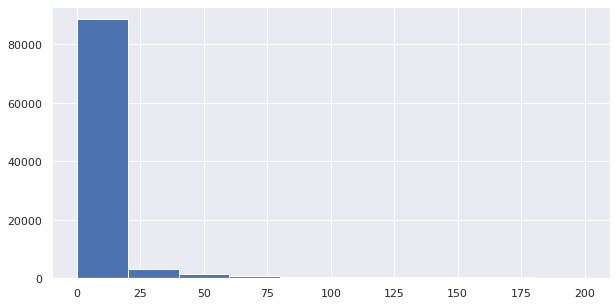

In [16]:
gap_data[gap_data < 200].hist()

In [17]:
gap_data.quantile(0.95)

59.760440972222156

In [0]:
treshold = 30 * 24 * 60 * 60

In [0]:
users_data = events_data.groupby('user_id', as_index=False).agg({'timestamp': 'max'}) \ 
                        .rename(columns={'timestamp': 'last_timestamp'})

In [0]:
users_data['is_gone_user'] = (events_data['timestamp'].max() - users_data.last_timestamp) > treshold

In [21]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [0]:
users_data = users_data.merge(users_scores, on='user_id', how='outer').fillna(0)

In [23]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [0]:
users_data = users_data.merge(users_events_data, on='user_id', how='outer').fillna(0)

In [0]:
days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [0]:
users_data = users_data.merge(days, on='user_id', how='outer')

In [0]:
users_data['passed_course'] = users_data.passed > 170

In [28]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
